In [1]:
import utulek
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

In [2]:
batch_size = 100
epochs = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
X, Y, labels = utulek.fetch_ds_cifar_10()
X = X.astype(np.float32) / 255
X_train, Y_train = X[:50000], Y[:50000]
X_test, Y_test = X[50000:], Y[50000:]
X_orig, Y_orig = X, Y

class Cifar10DatasetTrain(torch.utils.data.Dataset):
    def __len__(self):
        return len(X_train)

    def __getitem__(self, idx):
        return X_train[idx], Y_train[idx]
    

class Cifar10DatasetTest(torch.utils.data.Dataset):
    def __len__(self):
        return len(X_test)

    def __getitem__(self, idx):
        return X_test[idx], Y_test[idx]
    

train_dataset = Cifar10DatasetTrain()
test_dataset = Cifar10DatasetTest()

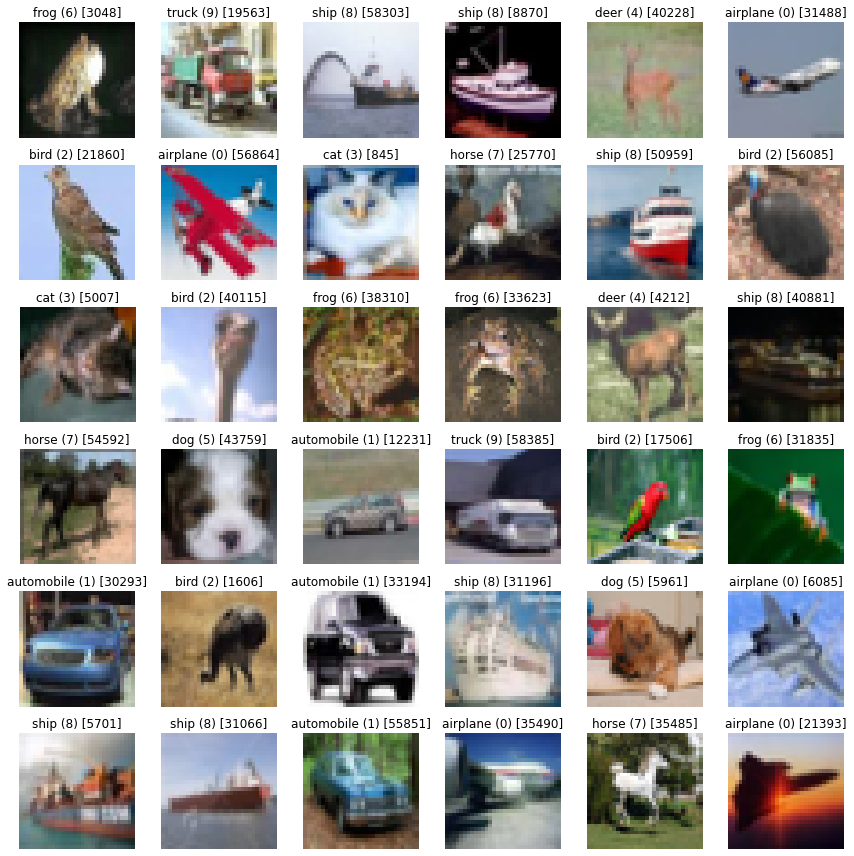

In [4]:
utulek.show_img_ds(X, Y, labels=labels, shape=(6, 6))

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

for X, Y in train_loader:
    X_shape = (X.shape, X.dtype)
    Y_shape = (Y.shape, Y.dtype)
    break
    
print(X_shape, Y_shape)

(torch.Size([100, 32, 32, 3]), torch.float32) (torch.Size([100]), torch.uint8)


In [6]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(32**2*3, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 10)
        )

    def forward(self, X):
        X = self.flatten(X)
        logits = self.linear_relu_stack(X)
        return logits


print(model := NeuralNetwork().to(device))

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=10, bias=True)
  )
)


In [7]:
%%time

import tqdm


calc_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)
model.train()

for epoch in tqdm.tqdm(range(epochs)):
    data = iter(train_loader)
    XY_next = data.next()
    XY_next = [i.to(device, non_blocking=True) for i in XY_next]
    
    for i in range(len(train_loader)):
        X, Y = XY_next
        if i + 1 != len(train_loader):
            XY_next = data.next()
            XY_next = [i.to(device, non_blocking=True) for i in XY_next]
        
        pred = model(X)
        loss = calc_loss(pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

model.eval()
size = len(test_loader.dataset)
num_batches = len(test_loader)
correct = 0
with torch.no_grad():
    for X, Y in test_loader:
        X, Y = X.to(device), Y.to(device)
        pred = model(X)
        correct += (pred.argmax(axis=1) == Y).type(torch.float).sum().item()

correct /= size
print(f"Accuracy: {(100*correct):>0.1f}%")

100%|████████████████████| 32/32 [01:36<00:00,  3.02s/it]


Accuracy: 31.5%
CPU times: user 2min 10s, sys: 16.1 s, total: 2min 26s
Wall time: 1min 37s


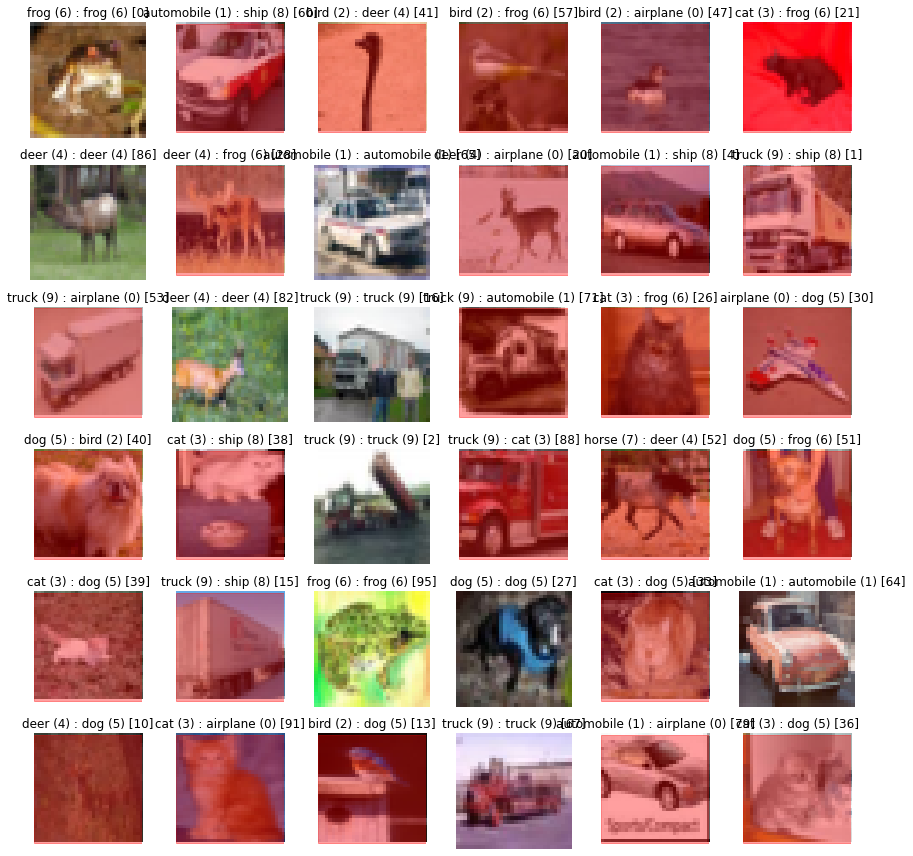

In [ ]:
pred = model(torch.from_numpy(X_orig[:100]).to(device)).argmax(axis=1)
utulek.show_img_ds(X_orig[:100], Y_orig[:100], pred, labels=labels, shape=(6, 6))